## Finding Malware in TLS with Machine Learning
- Presented by Bryan Scarbrough
- GSEC, GCIH, GCIA, GPYC, GXPN, GNFA, GCCC
- Master’s Degree Candidate at the SANS Technology Institute

The first stage of analysis is to import the required modules and then create a function to import the data for processing. Then we'll print the dataset to verify successful import.

---

In [111]:
%matplotlib inline

# Import some initial libraries to get started
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

# Set a random state variable for selection consistency
rand_state = 42

# Set malware label
label = 'malware_label'

# Function to import and format the dataset for processing
def get_data(sample_size, mal_percent=20, scaled=):
    csv_data_file = r'./test-train-data/test_train_data.csv'
    full_dataset = pd.read_csv(csv_data_file)

    # Scale data to 0-1 value for more efficient ML analysis
    if scaled:
        mm_data = MinMaxScaler().fit_transform(full_dataset)
        full_dataset = pd.DataFrame(mm_data, columns=full_dataset.columns)

    # Convert label values to 1 and -1 (this is how OC-SVM performs predictions
    # so validation requires these values
    ben = 1
    mal = -1
    full_dataset.loc[full_dataset[label] == 1, label] = mal
    full_dataset.loc[full_dataset[label] == 0, label] = ben

    # Split dataset into benign and malware
    benign = full_dataset[full_dataset.malware_label == ben]
    malware = full_dataset[full_dataset.malware_label == mal]
    
    # Determine malware percentage of sample dataset size
    mal_size = int((mal_percent / 100) * sample_size)

    # Prevent malware sample size from being larger than actual sample size
    if mal_size > malware.shape[0]:
        mal_size = malware.shape[0]

    # Generate random sample of malware of size determined by mal_size variable
    malware = malware.sample(n=mal_size, random_state=rand_state)

    # Prevent total sample size from being larger than actual sample size
    total_sample_size = sample_size - mal_size
    if total_sample_size > benign.shape[0]:
        total_sample_size = benign.shape[0]

    # Now generate a benign data sample and combine the benign and malware samples
    # to a single returned dataset
    benign = benign.sample(n=total_sample_size, random_state=rand_state)
    sampled_data = benign.append(malware).reset_index(drop=True)
    sampled_data = sampled_data.sample(frac=1).reset_index(drop=True)

    # Return sample dataset
    return sampled_data

# Generate initial full dataset for analysis
full_dataset = get_data(117000, )

# Drop rows with NaN (improperly calculated values rendered as Not-a-Number)
full_dataset = full_dataset.dropna()

# Print a sample of the 5K dataset
print(full_dataset)

        dom_in_tranco_1m  dom_dga_prob  otx_status  otx_age  urlhaus_status  \
0               0.000000      0.000208           0      0.0             0.0   
1               0.933333      0.034735           1    859.0             0.0   
2               0.000000      0.000390           0      0.0             0.0   
3               0.000000      0.000211           0      0.0             0.0   
4               0.000000      0.000214           0      0.0             0.0   
...                  ...           ...         ...      ...             ...   
116907          0.000000      0.000239           0      0.0             0.0   
116908          0.000000      0.000236           1   1335.0             0.0   
116909          0.000000      0.000349           0      0.0             0.0   
116910          0.000000      0.000522           1    408.0             0.0   
116911          0.000000      0.000292           0      0.0             0.0   

        urlhaus_age  ja3_urlhaus_status  ja3_urlhau

---

## Data Analysis

Before conducting any ML processing it is necessary to understand the nature of the data's relationship. This next stage steps through several phases to determine the significance of various data features and how they are related to one another.

### Data Distribution

Below is the percent distribution of Malware to Benign data.

---

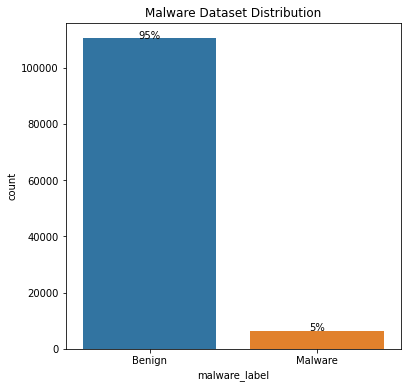

In [205]:
# Column to analyze
target = full_dataset[label]
# Get dataset length for percentage calculation
total = len(full_dataset)
# Define graph area and title
plt.figure(figsize = (6, 6))
plt.title("Malware Dataset Distribution")

# Generate count plot and turn into bar graph for display
ax = sns.countplot(target)
for p in ax.patches:
    percentage = '{:.0f}%'.format(p.get_height() / total * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 5
    ax.annotate(percentage, (x, y), ha = 'center')
    ax.set_xticklabels(['Benign', 'Malware'])

In [ ]:
---

## Cipher Suite Analysis

Now that we know the distribution of data, it is time to analyze some of the individual features. We will begin with Cipher Suties, the metadata value with the largest number of features. The first graph shows the number of unique cipher suites used by each data classification (benign and malware). The bottom graphs represent the most used cipher suites sorted by classification Benign importance on the left, and Malicious importance on the right.

---

<AxesSubplot:>

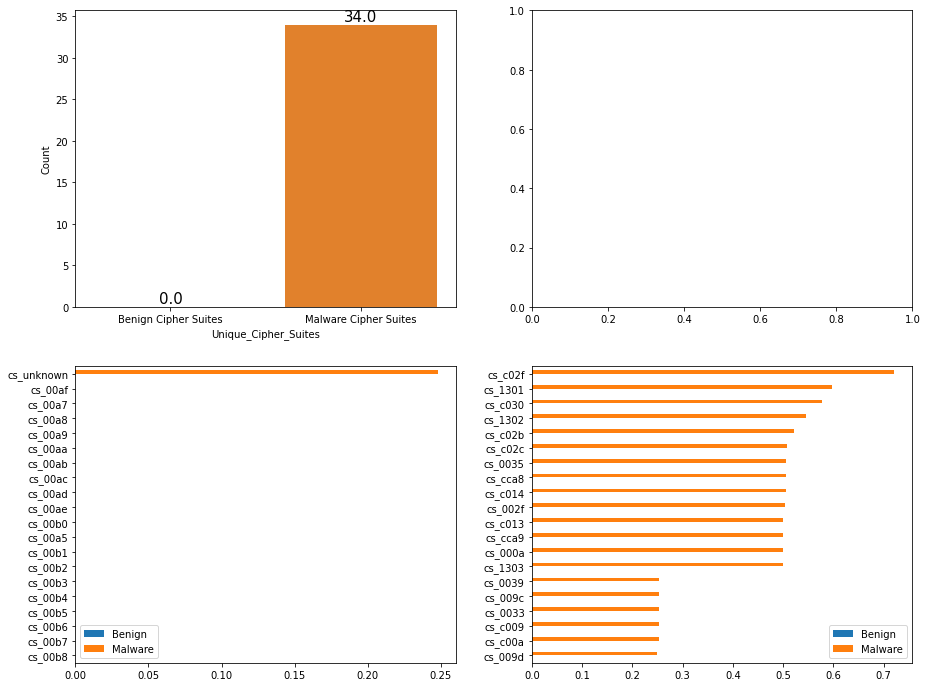

In [113]:
# Separate dataset by malware label
mal = full_dataset[full_dataset.malware_label == -1]
ben = full_dataset[full_dataset.malware_label == 1]

# Select only Cipher Suite columns
mal_cs_data = mal.filter(regex='cs_')
ben_cs_data = ben.filter(regex='cs_')

# Average Cipher Suite length value to graph in next cell
mal_cs_size = round(mal_cs_data['cs_len'].sum() / len(mal_cs_data['cs_len']), 2)
ben_cs_size = round(ben_cs_data['cs_len'].sum() / len(ben_cs_data['cs_len']), 2)

# Drop Cipher Suite length field - not related to number of CS values offered by client
mal_cs_data = mal_cs_data.drop(['cs_len'], axis=1)
ben_cs_data = ben_cs_data.drop(['cs_len'], axis=1)

# Drop columns containing only "0" values - these are CS values never offered by clients
# Then determine the length of remaining values to determine number of CS values
mal_cs_count = len(mal_cs_data.loc[:, (mal_cs_data != 0).any(axis=0)].columns)
ben_cs_count = len(ben_cs_data.loc[:, (ben_cs_data != 0).any(axis=0)].columns)

# Create graph container
fig, axes = plt.subplots(2, 2, sharex=False, figsize=(15,12))

# Calculate total number unique of Benign and Malware Cipher Suites used
cs_count = pd.DataFrame({'Unique_Cipher_Suites': ['Benign Cipher Suites', 'Malware Cipher Suites'], 'Count': [ben_cs_count, mal_cs_count]})
ax = sns.barplot(ax=axes[0,0], data=cs_count, y='Count', x='Unique_Cipher_Suites')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), ''),
                    (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                    size=15, xytext=(0, 8), 
                    textcoords='offset points')

# Sort cipher suites used by Benign importance
ben_cs_sum = pd.DataFrame({"Benign": (ben_cs_data.sum() / len(ben_cs_data)), "Malware": (mal_cs_data.sum() / len(mal_cs_data))}, index=ben_cs_data.sum().sort_values().index).tail(20)
ben_cs_sum.plot.barh(ax=axes[1,0], rot=0)

# Sorce cipher suites used by Malware importance
mal_cs_sum = pd.DataFrame({"Benign": (ben_cs_data.sum() / len(ben_cs_data)), "Malware": (mal_cs_data.sum() / len(mal_cs_data))}, index=mal_cs_data.sum().sort_values().index).tail(20)
mal_cs_sum.plot.barh(ax=axes[1,1], rot=0)

[Text(0.5, 0, 'Malware Src Port'), Text(0, 0.5, 'Count')]

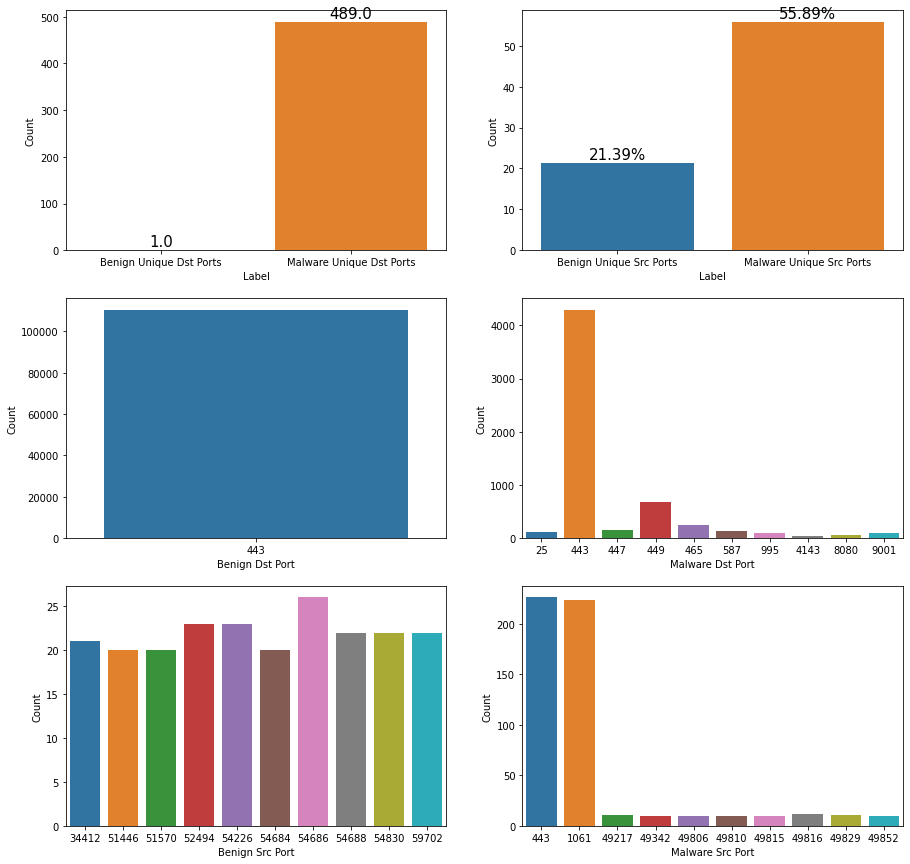

In [207]:
# PORT ANALYSIS
#
# Create dataframe of malicious and benign source and destination ports
mal_prt = mal[['src_port', 'dst_port']]
ben_prt = ben[['src_port', 'dst_port']]

# Create graph container
fig, axes = plt.subplots(3, 2, sharex=False, figsize=(15,15))

# Calculate and graph number of unique destination ports
ben_dst_percent = ben_prt.dst_port.unique().shape[0]
mal_dst_percent = mal_prt.dst_port.unique().shape[0]
dst_prt_sum = pd.DataFrame({'Label': ['Benign Unique Dst Ports', 'Malware Unique Dst Ports'], 'Count': [ ben_dst_percent, mal_dst_percent]})
ax = sns.barplot(ax=axes[0,0], data=dst_prt_sum, y='Count', x='Label')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), ''),
                    (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                    size=15, xytext=(0, 8), 
                    textcoords='offset points')

# Calculate and graph number of unique source ports
ben_src_percent = (ben_prt.src_port.unique().shape[0] / len(ben_prt.src_port)) * 100
mal_src_percent = (mal_prt.src_port.unique().shape[0] / len(mal_prt.src_port)) * 100
src_prt_sum = pd.DataFrame({'Label': ['Benign Unique Src Ports', 'Malware Unique Src Ports'], 'Count': [ ben_src_percent, mal_src_percent]})
ax = sns.barplot(ax=axes[0,1], data=src_prt_sum, y='Count', x='Label')
for bar in ax.patches:
    ax.annotate('{:.2f}%'.format(bar.get_height(), ''),
                    (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                    size=15, xytext=(0, 8), 
                    textcoords='offset points')

# Determine top benign destination ports
ben_dst_prt = pd.DataFrame(ben_prt.dst_port.astype(int).value_counts().sort_values())
ax = sns.barplot(ax=axes[1,0], data=cs_count, y=ben_dst_prt.dst_port, x=ben_dst_prt.index, orient='v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set(xlabel='Benign Dst Port', ylabel='Count')

# Determine top malware destination ports
mal_dst_prt = pd.DataFrame(mal_prt.dst_port.astype(int).value_counts().sort_values()).tail(10)
ax = sns.barplot(ax=axes[1,1], data=cs_count, y=mal_dst_prt.dst_port, x=mal_dst_prt.index, orient='v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set(xlabel='Malware Dst Port', ylabel='Count')

# Determine top benign source ports
ben_src_prt = pd.DataFrame(ben_prt.src_port.astype(int).value_counts()).head(10)
ax = sns.barplot(ax=axes[2,0], data=cs_count, y=ben_src_prt.src_port, x=ben_src_prt.index, orient='v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set(xlabel='Benign Src Port', ylabel='Count')

# Determine top malware sourceports
mal_src_prt = pd.DataFrame(mal_prt.src_port.astype(int).value_counts()).head(10)
ax = sns.barplot(ax=axes[2,1], data=cs_count, y=mal_src_prt.src_port, x=mal_src_prt.index, orient='v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set(xlabel='Malware Src Port', ylabel='Count')

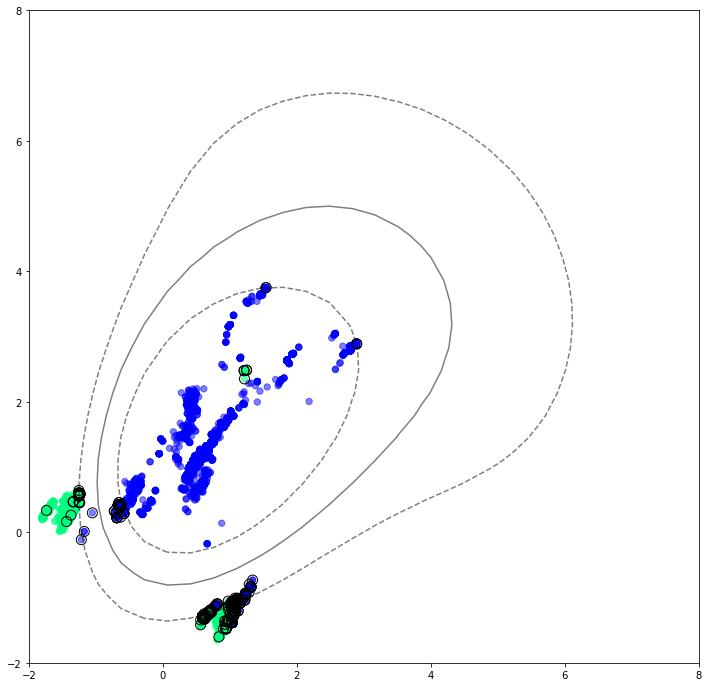

In [108]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
test_percent = 20

formatted_data = get_data(25000, 125, test_percent)

label_data = formatted_data.malware_label
feature_data = formatted_data.drop(label, axis=1)

pca = PCA(n_components=2).fit_transform(feature_data)
data = pd.DataFrame(pca)

svm_x_train, svm_x_test, svm_y_train, svm_x_test = train_test_split(data, label_data, test_size=(test_percent / 100), random_state=rand_state)

svclassifier = SVC(kernel='rbf', C=1, gamma=0.1, probability=True, random_state=42)
svclassifier.fit(svm_x_train, svm_y_train)
x_data = np.array(data)

plt.figure(figsize=(12,12))
plt.scatter(x_data[:, 0], x_data[:, 1], c=label_data.values, s=40, cmap=plt.cm.winter, alpha=0.5)
ax = plt.gca()
xlim = [-2, 8]
ylim = [-2, 8]
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svclassifier.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
ax.scatter(svclassifier.support_vectors_[:, 0], svclassifier.support_vectors_[:, 1],
            s=100, linewidth=1, facecolors='none', edgecolors='k')

In [86]:
from sklearn.svm import OneClassSVM

formatted_data = get_data(25000, 1, test_percent)
oc_benign = formatted_data[formatted_data.malware_label == 1]
oc_malware = formatted_data[formatted_data.malware_label == -1]

oc_b_train, oc_b_test = train_test_split(oc_benign, test_size=(test_percent / 100), random_state=rand_state)
oc_b_train = oc_b_train.drop(label, axis=1)

# Set nu and gamma hyperparameters (nu is expected percentage of malware in dataset)
nu_value = (len(oc_malware) / len(oc_b_test))

gamma_val = 0.1

oc_test = oc_b_test.append(oc_malware)
oc_test_label = oc_test.malware_label
oc_test = oc_test.drop(label, axis=1)

svclassifier = OneClassSVM(nu=nu_value, kernel='rbf', gamma=gamma_val)
svclassifier.fit(oc_b_train)

OneClassSVM(gamma=0.1, nu=0.01002004008016032)

In [87]:
from sklearn.model_selection import cross_val_score

def f_beta(beta, precision, recall):
    return (beta*beta + 1) * precision * recall / (beta * beta * precision + recall)

# Perform n-fold cross validation and calculate the mean score across the cv=## folds
print('\nCalculating OC-SVM scores...')
for val in ['accuracy', 'precision', 'recall']:
    score = cross_val_score(svclassifier, oc_test, oc_test_label, cv=2, scoring=val).mean()
    print("{}: {}".format(val, score))
    if val == 'precision':
        prec = score
    elif val == 'recall':
        rec = score
print("F2 Score: {}".format(f_beta(2.0, prec, rec)))



Calculating OC-SVM scores...
accuracy: 0.9827380952380953
precision: 1.0
recall: 0.9825453055716213
F2 Score: 0.9859873270724822


<AxesSubplot:>

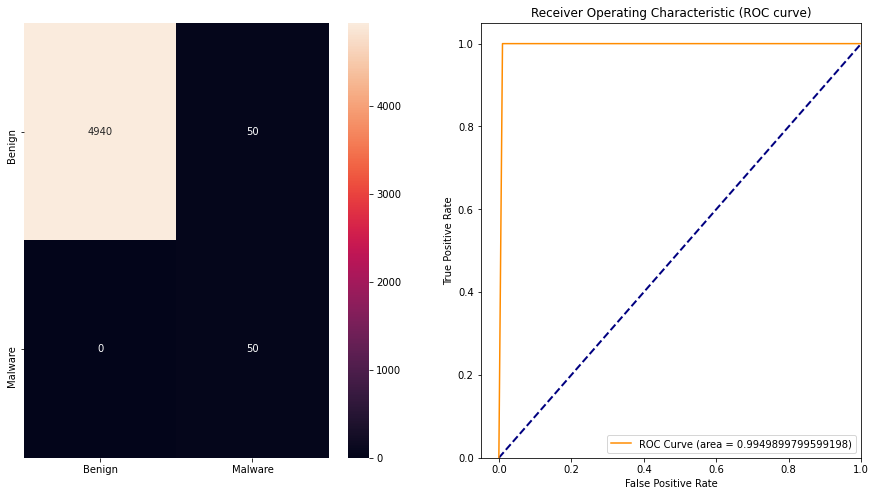

In [88]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

oc_pred = svclassifier.predict(oc_test)
ben = 0
mal = 1
oc_pred[oc_pred == 1] = 0
oc_pred[oc_pred == -1] = 1

oc_test_label[oc_test_label == 1] = 0
oc_test_label[oc_test_label == -1] = 1

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,8))

# Generate AUC graph
fpr, tpr, _ = roc_curve(oc_test_label, oc_pred)
auc = roc_auc_score(oc_test_label, oc_pred)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr, label='ROC Curve (area = {})'.format(str(auc)), color='darkorange')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC curve)')

# Generate Confusion Matrix
conf_matrix = confusion_matrix(oc_test_label, oc_pred)
sns.heatmap(conf_matrix, ax=ax1,
        xticklabels=['Benign', 'Malware'],
        yticklabels=['Benign', 'Malware'],
        annot=True, fmt='d')
